# Homework 3 - Places of the world

# 1. Data Collection

#### In this part of the homework, we focus on collecting the data that will be used by the search engine implemented in RQ2

## 1.1. Get the list of places

##### We want to collect the URL associated with the sites listed in the first 400 pages. To do that, we parse throught the pages and retrieve a list of all the links with `a`-tag and class equals to `content-card-place`.
##### Then we open in append mode a txt file in which we write all the elements of the list above created

In [1]:
import bs4
from bs4 import BeautifulSoup as bs
from tqdm import tqdm
import requests

import datetime
import os
import csv

import pandas as pd

In [36]:
# go through first 400 pages, extract places_urls and write them to txt_file_urls.txt
# the places_url are of the format https://www.atlasobscura.com/places/place_name

url_name = 'https://www.atlasobscura.com'
for i in range(400):
    result = requests.get('https://www.atlasobscura.com/places?page={}&sort=likes_count'.format(i+1))
    list_soup = bs(result.text)
    list_places = [x.get('href') for x in list_soup.find_all('a', {'class':'content-card-place'})]
    with open ('txt_file_urls.txt','a' ) as f:
        for el in list_places:
            f.write(url_name+el +'\n')

## 1.2. Crawl places

##### We are interested in saving each page in a different HTML file. Each file so created will store the HTML of the place and be placed in a folder with the other places that are listed in the corresponding page.
To do that, firstly we define the function `url_to_text_(urls)` that takes as argument a tuple that contains:
* the index of the page in which a URL is located (from 1 to 400)
* the URL of that place

In [568]:
# function that takes url, generates new directory if no places of the same page have been called before
# via requests.get(url) retrieve the html and store it in /htmls_page_{page_nr}/{place_name}

def url_to_text_(urls):
    i = urls[0]
    url = urls[1].split('\n')[0]
    try:
        os.makedirs('htmls_page_{}'.format(i+1))
    except:
        pass
    el = url
    el_name = el.split('.com/places/')[1]
    result = requests.get(el)
    with open('./htmls_page_{}/{}'.format(i+1, el_name), 'w') as wf:
        wf.write(result.text)


##### Then, we read the lines of `txt_file_urls.txt`, the file we previously created, and we build a tuple for each line (that represents the URL of a place). Each tuple groups the nuber of page in which the URL is located and the URL itself. Consequently, we create a list of all the tuples, and finally we call for each tuple the function `url_to_text_` defined above.

In [567]:
# looping over urls in txt_file_urls.txt in groups of 18 (nr places per site) 
# call the url_to_text_() function for each url

if __name__ == '__main__':
    with open ('txt_file_urls.txt', 'r') as urls: #reads the txt file
        l = [] # initialize a list
        for line in urls:
            l.append(line) # list of all urls
        grouped_l = [l[i:i+18] for i in range(0,len(l), 18)] # list of URLS listed for each page
        grouped_ln = [[(i, el) for el in group]for i, group in enumerate(grouped_l)] #list of tuples

        for group in grouped_ln: 
            for el in group:
                url_to_text_(el)     # get the HTMLs of the URLs and store in the corresponding file

## 1.3 Parse downloaded pages

##### In this point we want to create a tsv file for each HTML document. Such files will contain the following information:
1. Place Name (to save as placeName): String.
2. Place Tags (to save as placeTags): List of Strings.
3. Numberof people who have been there (to save as numPeopleVisited): Integer.
4. Number of people who want to visit the place(to save as numPeopleWant): Integer.
5. Description (to save as placeDesc): String. Everything from under the first image up to "know before you go" (orange frame on the example image).
6. Short Description (to save as placeShortDesc): String. Everything from the title and location up to the image (blue frame on the example image).
7. Nearby Places (to save as placeNearby): Extract the names of all nearby places, but only keep unique values: List of Strings.
8. Address of the place(to save as placeAddress): String.
9. Latitud and Longitude of the place's location(to save as placeAlt and placeLong): Floats
10. The username of the post editors (to save as placeEditors): List of Strings.
11. Post publishing date (to save as placePubDate): datetime.
12. The names of the lists that the place was included in (to save as placeRelatedLists): List of Strings.
13. The names of the related places (to save as placeRelatedPlaces): List of Strings.
14. The URL of the page of the place (to save as placeURL):String



![HTML page](https://github.com/lucamaiano/ADM/raw/master/2022/Homework_3/img/last_version_place.png)

##### We define the function `analyse_html` in order to:
* extract the requested information 
* write the information in a tsv file

In [ ]:
# function takes page_nr(equivalent to folder number), place_name
# for page_nr, place_name extract information from html, if NA set the information to ''
#
# use BeautifulSoup to extract the following information from html file
# placeName, placeTags, numPeopleVisited, numPeopleWant, placeDesc, placeShortDesc, placeNearby,
# placeAdress, placeAlt, placeLong, placeEditors, placePubDate, placeRelatedList, placeRelatedPlaces, placeURL
# the url is taken directly from the name variable
#
# write results to tsvs_page_{page_nr}/{place_name}.tsv containing all the 14 features

""" Function Summary:
    For page_nr, place_name extract information from html, if NA set ==''

    Args:
        - page_nr (int): page number
        - name (str): name of the place
        - to_tsv: boolean default True

    Returns:
        - return: write a tsvs file containing all the 14 features
"""

def analyse_html(page_nr, name, to_tsv = True): 
    
    with open('./htmls/htmls_page_{}/{}'.format(page_nr,name), 'r') as f:
        soup = bs(f.read())
    
    try:
        placeName = str(soup.find_all('h1', {'class':'DDPage__header-title'})[0].contents[0])
    except:
        placeName =''

    try:
        a = soup.find_all('a', {'class': 'itemTags__link js-item-tags-link'})
        placeTags = [el.get('href').split('/categories/')[1] for el in a]
    except:
        placeTags =''

    try:
        nrs = soup.find_all('div', {'class':'title-md item-action-count'})[:2]
        numPeopleVisited = int(nrs[0].get_text())
    except:
        numPeopleVisited=''

    try:
        nrs = soup.find_all('div', {'class':'title-md item-action-count'})[:2]
        numPeopleWant = int(nrs[1].get_text())
    except:
        numPeopleWant = ''

    try:
        place_desc = soup.find_all('div', {'class': 'DDP__body-copy'})
        text = ''.join([el.get_text() for el in place_desc])
        placeDesc = text.replace('\n', '').replace('\xa0', '')
    except:
        placeDesc=''

    try:
        placeShortDesc = soup.find_all('h3', {'class': 'DDPage__header-dek'})[0].contents[0]
    except:
        placeShortDesc=''

    try:
        side = soup.find_all('div', {'class':'DDPageSiderailRecirc__item-title'})
        placeNearby = [s.get_text() for s in side]
    except:
        placeNearby = ''

    try:
        a=soup.find_all('address', {'class':'DDPageSiderail__address'})[0]
        placeAdress = a.find('div').get_text(separator = ' ').split('\n')[0]
    except:
        placeAdress = ''

    try:
        b=soup.find('div', {'class':'DDPageSiderail__coordinates js-copy-coordinates'})
        lat,lng = b.get('data-coordinates').split(',')
        placeAlt = float(lat)
        placeLong = float(lng)
    except:
        placeAlt = ''
        placeLong = ''


    try:
        contributors = soup.find_all('div', {'class': 'ugc-editor-icons'})
        href = [c.findChildren('a')[0].get('href') for c in contributors]
        #alt = [c.findChildren('img')[0].get('alt') for c in contributors]
        placeEditors = [h.split('/users/')[1] for h in href]
    except:
        placeEditors = ''

    try:    
        date = soup.find_all('div', {'class': 'DDPContributor__name'})
        dt_string = date[0].get_text()
        format = "%B %d, %Y"
        placePubDate = datetime.datetime.strptime(dt_string, format)
    except:
        placePubDate= ''

    try:
        pot = soup.find_all('div', {'class':'CardRecircSection__title'})
        lists = [o for o in pot if o.text == 'Appears in 1 List'][0]
        pl = lists.find_all_next('h3', {'class':'Card__heading --content-card-v2-title js-title-content'})
        placeRelatedLists = [el.find('span').text for el in pl]
    except:
        placeRelatedLists = ''

    try:
        pot = soup.find_all('div', {'class':'CardRecircSection__title'})
        rel = [o for o in pot if o.text == 'Related Places'][0]
        pl = rel.find_all_next('div', {'class':'Card__action-btns vue-js-been-there-everywhere-place'})
        placeRelatedPlaces = [p.get('data-place-title') for p in pl]
    except:
        placeRelatedPlaces=''

    try:
        placeURL = 'https://www.atlasobscura.com/places/'+name
    except:
        placeURL = ''
        
    info = [placeName, placeTags, numPeopleWant, numPeopleVisited, placeDesc, placeShortDesc, placeNearby, placeAdress, placeAlt, placeLong, placeEditors, placePubDate, placeRelatedLists, placeRelatedPlaces, placeURL]
   
    if to_tsv:
        with open ('tsvs_page_{}/{}.tsv'.format(i+1, name), 'w') as f:
            writer = csv.writer(f, delimiter='\t')
            writer.writerow(info)
            

##### Then, we loop over the pages and for each place we write the information in a tsv file using the above implemented function `analyse_html`

In [ ]:
# loop through html files and extract relevant data by calling analyse_html()

for i in range(400):
    els = os.listdir('./htmls/htmls_page_{}'.format(i+1))
    os.makedirs('tsvs_page_{}'.format(i+1))

    for name in els:
        analyse_html(i+1, name)

# 2. Search Engine

#### This part of the Homework deals with creating two search engines. The search engines will be build in subsection *2.1* and *2.2*

## 2.1. Conjunctive Query

##### We define functions that: process a String input using the nltk package, build dictionaries that map Strings to term_id, build a dictionary that maps term_ids to the documents with occurences of the term
##### In a second step we use the built dicitonaries to find the subset of places whose descriptions contain all the query words entered by a user

### 2.1.1 Create your index!

In [2]:
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
import re

from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

##### Firstly, we define a function `description_to_stems` that takes a String input and returns a list of processed words

In [3]:
# function takes a description in string format, consecutively does:
# to lower case, remove stopwords, remove punctutaion, stemming, removing words with len()<=1

def description_to_stems(desc):
    
    lower = desc.lower()
    
    stopword = set(stopwords.words('english'))

    word_tokens = RegexpTokenizer('\s', gaps=True).tokenize(lower)

    regex = r"[!\"#\$%&\“\”\'\(\)\*\+,-\./:;<=>\?@\[\\\]\^_`{\|}~]"
    no_stops = [re.sub(regex, '', w) for w in word_tokens if not w in stopword]

    stemmer = SnowballStemmer('english')
    stems = [stemmer.stem(w) for w in no_stops if len(stemmer.stem(w))>1]

    words = stems
    return words

In [5]:
# looping pages and places.tsv; read the description and pass to the preprocessing function description_to_stems()
# sequence of words returned that are stored in a dictionary, that maps str -> nr of elements added before (lenght of dict)

vocabulary = {}

for i in range(400):
    els = os.listdir('./tsvs/tsvs_page_{}'.format(i+1))

    for name in tqdm(els):
        with open ( './tsvs/tsvs_page_{}/{}'.format(i+1, name), 'r', encoding = "utf-8") as f:
            tsv_reader = csv.reader(f, delimiter="\t")
            for row in tsv_reader:# if i ==4][0]
                desc = row[4]
                words = set(description_to_stems(desc))
                
                for word in words:
                    if word not in vocabulary.keys():
                        vocabulary[word] = int(len(vocabulary))

100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 110.17it/s]


In [6]:
# saving the vocabulary dictionary to csv

with open("vocabulary.csv", "w", encoding = 'utf-8') as voc_f:
    w = csv.writer(voc_f)
    for key, val in vocabulary.items():
        w.writerow([key, val])


In [11]:
# preprocessing the descriptions, map documents words to index and generate a dict
# of index -> page_index/documentname.tsv

mapping = {}

for i in range(400):
    els = os.listdir('./tsvs/tsvs_page_{}'.format(i+1))

    for name in tqdm(els):
        with open ( './tsvs/tsvs_page_{}/{}'.format(i+1, name), 'r', encoding="utf-8") as f:
            tsv_reader = csv.reader(f, delimiter="\t")
            for row in tsv_reader:
                desc = row[4]
                words = set(description_to_stems(desc))
                for word in words:
                    idx = vocabulary[word]
                    try:
                        mapping[idx].append(str(i+1)+'/'+name) 
                    except:
                        mapping[idx] = [str(i+1)+'/'+name] 

100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 209.11it/s]


In [8]:
# saving the term_id to document_name dictionary to csv

with open("termid_document.csv", "w", encoding ='utf-8') as map_f:
    w = csv.writer(map_f)
    for key, val in mapping.items():
        w.writerow([key, val])

In [4]:
# given a string input all words separated by blank space are mapped to the vocabulary index, 
# which is used to retreive all documents that contain the word using the termid_document dictionary.
# the intersection of matching document sets is determined and the document names returned, if none matches returns ''

def docs_matching_query(inp):
    sub_matches = []
    for el in inp.split(' '):
        try:
            idx = vocabulary[el]
            subm = mapping[idx]
            sub_matches.append(subm)
        except:
            pass    
    try:
        both = set(sub_matches[0])
        for sub_query in sub_matches:
            both = both.intersection(sub_query)
    except:
        both = ''
        
    return both


### 2.1.2. Execute the query

##### We test our search engine with the query 'american horror'. 
* Firstly the function `description_to_stems` is called and the String input passed as argument. 
* The returned processed String is the passed to the function `docs_matching_query` which return the list of matching documents. 
* Finally we call the function `print_matches_df` which reads the matching documents and print the placeName, placeDesc and placeURL in table format.

In [37]:
# print data of the matching documents

def print_matches_df(docs):
    dfs = []
    for el in docs:
        i, name = el.split('/')
        with open ( './tsvs/tsvs_page_{}/{}'.format(int(i), name), 'r') as f:
            tsv_reader = csv.reader(f, delimiter="\t")
            for row in tsv_reader:# if i ==4][0]
                new_df = pd.DataFrame([row[0], row[4], row[14]]).T
                dfs.append(new_df)

    df = pd.concat(dfs)
    df.columns=['placeName', 'placeDesc', 'placeURL']
    df = df.reset_index()
    del df['index']

    return df

In [57]:
inp = str(input())
inp = ' '.join(description_to_stems(inp))
docs = docs_matching_query(inp)
df = print_matches_df(docs)
df

american horror


,placeName,placeDesc,placeURL
0,Grave of Ed Gein,"While not technically a serial killer, the ter...",https://www.atlasobscura.com/places/plainfield...
1,Buckhorn Saloon and Museum,Drink a beer whilst you admire stuffed cougars...,https://www.atlasobscura.com/places/buckhorn-s...
2,PsychoBarn,If you’re casually strolling down Piccadilly a...,https://www.atlasobscura.com/places/psychobarn
3,Clown Motel,While Nevada’s Clown Motel may seem like the p...,https://www.atlasobscura.com/places/clown-motel
4,Scary Dairy,There is something inherently spooky about aba...,https://www.atlasobscura.com/places/scary-dairy
5,Texas Triffid Ranch,Billing itself as “Dallas’s pretty much only c...,https://www.atlasobscura.com/places/texas-trif...
6,Rosenheim Mansion,The mansion Hollywood loves to love.Architect ...,https://www.atlasobscura.com/places/rosenheim-...
7,Prince Demetrius Gallitzin Crypt,In a small underground crypt in the Allegheny ...,https://www.atlasobscura.com/places/prince-dem...
8,Murals of Maxo Vanka,Created in protest against industrial capitali...,https://www.atlasobscura.com/places/murals-of-...
9,"""Ju-On: The Grudge"" House",This infamous housemade famous by director Tak...,https://www.atlasobscura.com/places/juon-the-g...


## 2.2. Conjunctive Query & Ranking Score

##### In this section we improve the query results by including the termfrequency in the set of our documents. Upon applying a conjunctive query the matching documents of places are sorted by their cosine similarity to the input query.

### 2.2.1. Inverted index

##### Using the mapping of term_id to documents we create a dictionary 'weights' that contains the weight for all the terms in our vocabulary.
##### We produce a new dictionary (combining the original mapping with the weights) that we name mapping_tfidf which stores data in the format term_id : (document_name, tf_idf). 

In [5]:
import numpy as np
from collections import Counter
import pandas as pd

In [13]:
# weights for each word in vocabulary, term_id -> weight_term
# the term_id and the number of documents in which they occur are taken from the mapping dictionary (term_id -> list of docs)

weights = {}
n = 7200

for key in mapping.keys():
    weights[key] = np.log(n/len(mapping[key]))

In [30]:
# mapping terms to list of (file_name, tf-idf)
# tf-idf = tfj * wj = tfj * log(n/nj) n = 7200
# going through the tsvs, read the description, preprocess it and calculate the weighted frequency
# using the precalculated weights for each word. 

mapping_tfidf = {}
for i in range(400):
    els = os.listdir('./tsvs/tsvs_page_{}'.format(i+1))

    for name in tqdm(els):
        with open ( './tsvs/tsvs_page_{}/{}'.format(i+1, name), 'r', encoding = 'utf-8') as f:
            tsv_reader = csv.reader(f, delimiter="\t")
            for row in tsv_reader:
                desc = row[4]
                words = description_to_stems(desc)
                ln = len(words)
                
                counter = Counter(words)
                for word in counter:
                    idx = vocabulary[word]
                    freq = counter[word]/ln*weights[idx] # == tf
                    try:
                        mapping_tfidf[idx].append( (str(i+1)+'/'+name, freq) )
                    except:
                        mapping_tfidf[idx] = [ (str(i+1)+'/'+name, freq) ]

100%|██████████████████████████████████████████| 18/18 [00:00<00:00, 196.96it/s]


In [31]:
# writing freq_mapping to csv

with open("termid_document_freq.csv", "w", encoding = 'utf-8') as map_ffreq:
    w = csv.writer(map_ffreq)
    for key, val in mapping_tfidf.items():
        w.writerow([key, val])

##### Implementation of  `cos_rel_similarst_2` which returns the top k places given an input query. An initial set of places returned by a conjunctive query is filtered to return the top k places that have the highest cosine similarity with the input query.

In [6]:
# corrected cosine similarity function implementing heapq
# takes string of input (preprocessed and in the format in which it is passed to docs_matching_query() )
# and the list of documents returned by docs_matching_query(), int k the number of top elements to be returned 

# read matching document_description, count occurence of the words that are in the input_query/len(description)

# the cosine similarity is ~ to vector_of_words_in_match/len(vector_of_words_in_match)
# since all dimensions but the words of the input query are orthogonal we can look only at the values in 
# that dimension and normalize by the length of the whole vector_of_words_in_match==len(description)
# weight the similarity using weights stored in dictionary 'weights'


import heapq

def cos_rel_similarst_2(inp, matches, k):
    inps = inp.split(' ')
    ln_inp  = len(inps)
    counter_inp = Counter(inps)
    mar_inp = sum( (counter_inp[word]*weights[vocabulary[word]]/ln_inp )**2 for word in counter_inp)
    mar_inp = np.sqrt(mar_inp)
    
    heap = []
    
    for match in matches:
        i, name = match.split('/')
        with open ( './tsvs/tsvs_page_{}/{}'.format(int(i), name), 'r', encoding="utf-8") as f:
            tsv_reader = csv.reader(f, delimiter="\t")
            for row in tsv_reader:
                desc = description_to_stems(row[4])
                ln_desc = len(desc)
                counter_desc = Counter(desc)
                mar_desc = sum( (counter_desc[word]*weights[vocabulary[word]]/ln_desc )**2 for word in counter_desc)
                mar_desc = np.sqrt(mar_desc)
                
                sim = sum(counter_desc[sub_query]/ln_desc*weights[vocabulary[sub_query]] * counter_inp[sub_query]/ln_inp*weights[vocabulary[sub_query]]  for sub_query in inps)
                sim = sim/mar_inp/mar_desc
                el = (sim, row[0], row[4], row[14])
                
                if len(heap)< k:
                    heapq.heappush(heap, el)
                elif heap[0][0] < sim:
                    heapq.heapreplace(heap, el)
    return heap

### 2.2.2. Execute the query

##### We test our search engine with the  input 'american horror'. The input is processed and passed to the function `docs_matching_queries` defined in section 2.1. the returned matching documents are then filtered for highest cosine similarity by passing the input and the 'matches' to `cos_rel_similarst_2`

In [82]:
inp = str(input())
inp = ' '.join(description_to_stems(inp))
matches = docs_matching_query(inp)

american horror


##### We print the top k results in descending order to a table

In [84]:
top_k_heap = cos_rel_similarst_2(inp, matches, 3)
els = [top for top in top_k_heap]
df = pd.DataFrame(els)
                      
df.columns=['Similarity', 'placeName', 'placeDesc', 'placeURL']
df = df.sort_values(by='Similarity', ascending = False)
df = df.reset_index(drop=True)
df

,Similarity,placeName,placeDesc,placeURL
0,0.163077,"""Ju-On: The Grudge"" House",This infamous housemade famous by director Tak...,https://www.atlasobscura.com/places/juon-the-g...
1,0.139466,Amityville Horror House,"On a cold November night in 1974, Amityville, ...",https://www.atlasobscura.com/places/amityville...
2,0.108776,Clown Motel,While Nevada’s Clown Motel may seem like the p...,https://www.atlasobscura.com/places/clown-motel


In [86]:
# importing dictionaries ?
# read vocabulary and mapping from 2.1
# vocabulary: trimmed word -> int
# mapping: int -> page_site/place_name (, freq_id)
# while reading the vocabulary is reliable the mapping is not conserved, recommend to rerun mapping and mapping_tfidf if reopen notebook
'''
import csv
import sys

csv.field_size_limit(sys.maxsize) #!

with open('vocabulary.csv', mode='r', encoding = 'utf-8') as infile:
    reader = csv.reader(infile)
    vocabulary = {rows[0]:rows[1] for rows in reader}

with open('termid_document.csv', mode='r', encoding = 'utf-8') as infile2:
    reader2 = csv.reader(infile2)
    mapping = {rows[0]:list(rows[1].replace('[', '').replace(']', '').replace("'", '').split(',')) for rows in reader2}

with open("termid_document_freq.csv", "r", encoding = 'utf-8') as infile3:
    reader3 = csv.reader(infile3)
    mapping_tfidf = {int(rows[0]): list(rows[1].replace('[', '').replace(']', '').replace("'", '').replace('),', ')),').split('),')) for rows in reader3}
'''

# 3. Define a new score!

##### In this section we define a new scoring function that allows us to return a sorted list of matching places.

In [7]:
# read the vocabulary dictionary from csv
import csv
import sys

with open('vocabulary.csv', mode='r', encoding="utf-8") as infile:
    reader = csv.reader(infile)
    vocabulary = {rows[0]:int(rows[1]) for rows in reader}

##### The user is prompted to enter a general query. He then may enter additional parameters from a set of options including: Place, Category and Coordinates. The entered parameters are stored in param_dict for usage.

In [8]:
print("Query?")
query = str(input())
query = ' '.join( description_to_stems(query) )

param_dict = {}

def define_param(param_list):
    print("Define another parameter!")
    print("Options: ", param_list)
    param = str(input())

    while param not in param_list:
        print("Wrong parameter!")
        param = str(input())
    
    
    if param == "place" or param == "category":
        print("Value?")
        value = str(input())
        param_dict[param] = value 
        param_list.remove(param)
        
    elif param == "coordinates":
        print("Latitude?")
        lat = int(input())
        while (lat > 180 or lat < -180):
            print("wrong! latitude has to be between -180 and 180")
            lat = int(input())
    
        print("Longitude?")
        lon = int(input())    
        while (lon > 90 or lon < -90):
            print("wrong! latitude has to be between -90 and 90")
            lon = int(input()) 
            
        param_dict[param] = (lat, lon)
    
        param_list.remove(param)
    
    return param_list
    
    
param_list = ["place", "coordinates", "category", "none"]

other = "yes"
while other == "yes":
    print("Do you want to define an other parameter? yes/no")
    other = str(input())
    while other not in ["yes", "no"]:
        print("Wrong answer!")
        other = str(input())
    if other == "yes":
        param_list = define_param(param_list) 

Query?
castle
Do you want to define an other parameter? yes/no
yes
Define another parameter!
Options:  ['place', 'coordinates', 'category', 'none']
italy
Wrong parameter!
place
Value?
Italy
Do you want to define an other parameter? yes/no
yes
Define another parameter!
Options:  ['coordinates', 'category', 'none']
coordinates
Latitude?
30
Longitude?
30
Do you want to define an other parameter? yes/no
no


In [9]:
param_dict

{'place': 'Italy', 'coordinates': (30, 30)}

##### The new score is defined as:  <br>
* 50% cosine similarity <br>
* 20% place <br>
* 20% category <br>
* 10% coordinates <br>

##### All matches returned by `docs_matching_query` are read and sorted regarding their similarity to the query.
* All matches returned by 
* We use the cosine similarity to introduce a more specific scoring for the similarity between initial query and place description.
* If other parameters were entered by the user the corresponding information available for the places is calculated and added to an overall score

> * place: if the adress of the place includes the query term, add +0.2 to the score
> * category: if the category of the place includes the category specified by the user, add +0.2 to the score
> * coordinates: calculate the euclidean distance between entered and actual longitude and latitude. Add a score between 0-1


In [14]:
query_score = {}

#cosine_similarity
matches = docs_matching_query(query)
top_k_heap = cos_rel_similarst_2(query, matches, len(matches))
for result in top_k_heap:
    #map between 0 and 0.5
    query_score[result[1] ] = {}
    query_score[result[1] ]["placeName"] = result[1]
    query_score[result[1] ]["Similarity"] = result[0] / 2
    query_score[result[1] ]["placeDesc"] = result[2]
    query_score[result[1] ]["placeURL"] = result[3]

In [15]:
#other parameters
for match in matches:
    match_split = match.split("/")
    with open ('./tsvs/tsvs_page_{}/{}'.format(match_split[0], match_split[1]), 'r', encoding ="utf-8") as f:
        tsv_reader = list(csv.reader(f, delimiter="\t"))[0]
        
        #place
        if "place" in param_dict:
            place = param_dict["place"]
            address = tsv_reader[-8]
            if place in address:
                query_score[tsv_reader[0]]["Similarity"] += 0.2
                
        #category
        if "category" in param_dict:
            category = param_dict["category"]
            categories = tsv_reader[1]
            if category in categories:
                query_score[tsv_reader[0]]["Similarity"] += 0.2
                
        #coordinates
        if "coordinates" in param_dict:
            param_lat = param_dict["coordinates"][0]
            param_lon = param_dict["coordinates"][1]
            lat = float(tsv_reader[-7])
            lon = float(tsv_reader[-6])
            diff_lon = abs(lat - param_lat)
            diff_lat = abs(lon - param_lon)
            difference = diff_lon + diff_lat
            #map between 0 and 0.1,  540 max difference
            query_score[tsv_reader[0]]["Similarity"] += (1-difference/540)

##### Return a table of sorted matches sorted by overall similarity, as defined by our score function. 
> The displayed table is returned for the query: 'castle', 'place': 'Italy', 'coordinates': (30, 30)

In [16]:
l = []
for d in query_score:
    l.append((query_score[d]['Similarity'],query_score[d]['placeName'],query_score[d]['placeDesc'],query_score[d]['placeURL']))

df = pd.DataFrame(l)
                      
df.columns=['Similarity', 'placeName', 'placeDesc', 'placeURL']
df = df.sort_values(by='Similarity', ascending = False)
df = df.reset_index(drop=True)

df

,Similarity,placeName,placeDesc,placeURL
0,1.239132,Corvin Castle,"In the heart of Transylvania, one of Europe’s ...",https://www.atlasobscura.com/places/corvin-castle
1,1.225967,Rocchetta Mattei,"Evenfrom the outside, the looming fortress kno...",https://www.atlasobscura.com/places/rocchetta-...
2,1.214039,Sammezzano Castle,An overlooked Italian marquis left behind one ...,https://www.atlasobscura.com/places/sammezzano...
3,1.207205,Medieval Village,"The Medieval Village in Turin, placed in Valen...",https://www.atlasobscura.com/places/medieval-v...
4,1.195671,Neuschwanstein Castle,"Sleeping Beauty Castle at Disneyland, Cinderel...",https://www.atlasobscura.com/places/neuschwans...
...,...,...,...,...
318,0.714331,Banff Springs Hotel,A former Canadian Pacific Railway hotel built ...,https://www.atlasobscura.com/places/banff-spri...
319,0.713832,Miniature World,The Empress is the most famous hotel in Victor...,https://www.atlasobscura.com/places/miniature-...
320,0.710457,Portland Troll Bridge,Quite why trolls began to appear under a bridg...,https://www.atlasobscura.com/places/portland-t...
321,0.707934,The Enchanted Forest,Artist Doris Needham and her husband Ernest ne...,https://www.atlasobscura.com/places/enchanted-...


In [17]:
top_k_heap

[(0.013748277708386028,
  'Murals of Maxo Vanka',
  'Created in protest against industrial capitalism, World War I, and the rise of Fascism, the paintings are the work of aCroatian expatriate artist, Maximilijan “Maxo” Vanka, referred to by David Byrne of the Talking Heads as “The Diego Rivera of Pittsburgh.” If you prefer legend to history, that’s here too - St. Nicholas Catholic Church is also the site of one of Pittsburgh’slesser-known ghost stories.Maxo Vanka (1889-1963) is most likely the illegitimate child of Hapsburg nobility. Born in the days when Croatia was stillpart of the Austro-Hungarian Empire, the infant Vanka was given to a peasant woman named Dora and raised in a small village outside of Zagreb. At the age of eight, his maternal grandfather learned of his existence and brought him to a castle to be educated. Vanka went on to study art in Zagreb and Brussels, graduating with top honors in 1914, the year World War I broke out. The 25-year-old artist–already a confirmed p

# 4. Visualizing the most relevant places

##### We utilize `plotly Mapbox` to graphically represent the matching locations and relevant information found in 3.

##### Looping over matching places , we read the corresponding tsv files and extract relevant data. We use the package pycountry to generate a list of countries, which are extracted from the address section in the tsvs. The relevant parameters for our locations include:
* Name
* Address
* Country
* Number of Visitors
* Latitude & Longitude
* Url
* The similarity scores from section 3.

In [113]:
import pycountry
countries = [c.name for c in pycountry.countries]

info = []
for match in matches:
    match_split = match.split("/")
    with open ('./tsvs/tsvs_page_{}/{}'.format(match_split[0], match_split[1]), 'r', encoding ="utf-8") as f:
        tsv_reader = list(csv.reader(f, delimiter="\t"))[0]
        
        name = tsv_reader[0]
        placeTags = tsv_reader[1]
        address = tsv_reader[-8]
        #city = address[0]
        country = re.sub(r'\d','',address.split(',')[-1]).lstrip(' ')
        double_names = ['United States', 'United Kingdom']
        
        if 'United' in country:
            country_ = 'United'+country.split('United')[1]
        else:
            country_ = [c for c in country.split() if c in countries]
            
        vis = int(tsv_reader[2])
        lat = float(tsv_reader[-7])
        lng = float(tsv_reader[-6])
        url = tsv_reader[-1]
        sim = float(df[df['placeURL']==url]['Similarity']) # using the similarity score defined in 3.

        info.append([name, placeTags, address, country_, vis, lat, lng, url, sim])

In [125]:
map_df = pd.DataFrame(info)
map_df.columns = ['placeName', 'placeTags', 'placeAddress', 'Country', 'numPeopleVisited', 'placeAlt', 'placeLong', 'placeURL', 'Score']
map_df

,placeName,placeTags,placeAddress,Country,numPeopleVisited,placeAlt,placeLong,placeURL,Score
0,Nautilus Foundation,"['secret-passages', 'sculpture-gardens', 'hous...","Monticello, Florida, 32344 United States",United States,411,30.4740,-84.0006,https://www.atlasobscura.com/places/nautilus-f...,0.805962
1,Lauriston Castle,"['furniture', 'estates', 'castles', 'collectio...","2A Cramond Rd S Edinburgh, Scotland United Kin...",United Kingdom,872,55.9712,-3.2785,https://www.atlasobscura.com/places/lauriston-...,0.975775
2,Cisternerne,"['subterranean', 'underground', 'subterranean-...",Cisternerne i Søndermarken Frederiksberg Denmark,[Denmark],1076,55.6695,12.5249,https://www.atlasobscura.com/places/cisternerne,0.945430
3,Green Vault,"['museums-and-collections', 'museums']","Taschenberg 2 Dresden, 01067 Germany",[Germany],533,51.0519,13.7360,https://www.atlasobscura.com/places/green-vault,0.957672
4,Bannerman's Castle,"['modern-castles', 'weapons', 'islands', 'aban...","90 Front St Beacon, New York, 12508 United States",United States,1961,41.4553,-73.9889,https://www.atlasobscura.com/places/bannermans...,0.853329
...,...,...,...,...,...,...,...,...,...
318,Portland Troll Bridge,"['trolls', 'dolls', 'toys', 'local-history', '...","16498 NW McNamee Rd Portland, Oregon United St...",United States,1514,45.6473,-122.8477,https://www.atlasobscura.com/places/portland-t...,0.710457
319,The Village of Monsanto,"['intriguing-environs', 'outsider-architecture...","Idanha-a-Nova, 6060-091 Portugal",[Portugal],1485,40.0394,-7.1142,https://www.atlasobscura.com/places/village-of...,0.933814
320,Franklin Castle,"['aletrail', 'mansions', 'haunted', 'legends',...","4308 Franklin Boulevard Cleveland, Ohio United...",United States,1197,41.4858,-81.7166,https://www.atlasobscura.com/places/franklin-c...,0.869447
321,The Cloisters of the Ancient Spanish Monastery,"['outsider-architecture', 'sacred-spaces', 'ar...","16711 West Dixie Highway North Miami Beach, ...",United States,1819,25.9304,-80.1544,https://www.atlasobscura.com/places/cloisters-...,0.807514


##### Testing on the input query 'castle' as done in 3. we opt for the option of visualizing the number of visitors by the size of the locations pin and the place score by color.

In [111]:
import matplotlib.pyplot as plt
import plotly.express as px

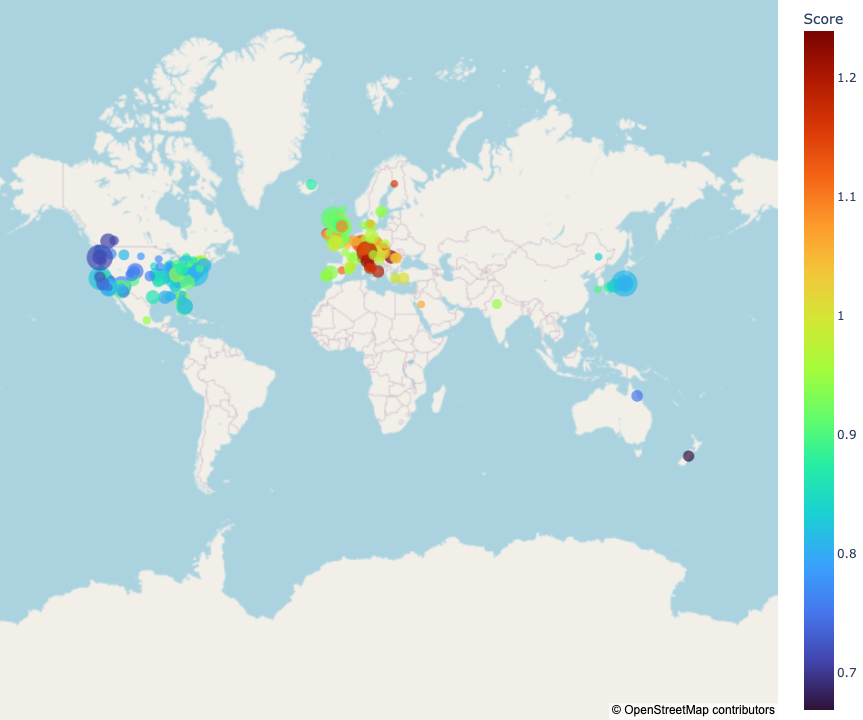

In [127]:
fig = px.scatter_mapbox(map_df, lat="placeAlt",lon="placeLong",hover_name="placeName",hover_data = ["numPeopleVisited","placeAddress","Country"],
                       color="Score", zoom=3,height=300, size= "numPeopleVisited",
                       labels={"placeAlt":"Lat.","placeLong":"Long.","placeAddress":"Address","numPeopleVisited":"Number of Visitors"},
                    color_continuous_scale=px.colors.sequential.Turbo)

fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
fig.show()


# 5. Bonus

In [15]:
print("What do you want to do?\n1-Define new parameters\n2-Define users\n3-specify tags\n4-filter based on visitors\n5-specify list names")
query = str(input())

What do you want to do?
1-Define new parameters
2-Define users
3-specify tags
4-filter based on visitors
5-specify list names
3


In [17]:
if query == 1:
    "Do you want to define new parameteres? yes/no"
    ans = str(input())
    if ans == yes:
        print("Place name")
        name = description_to_stems(str(input()))
        print("Address")
        address = description_to_stems(str(input()))
        print("Description")
        desc = description_to_stems(str(input()))
    
    desc = ' '.join(description_to_stems(desc) )
    matches = docs_matching_query(desc)

    for match in matches:
        match_split = match.split("/")
        with open ('./tsvs/tsvs_page_{}/{}'.format(match_split[0], match_split[1]), 'r', encoding ="utf-8") as f:
            tsv_reader = list(csv.reader(f, delimiter="\t"))[0]
            if address in tsv_reader[-8] and name in tsv_reader[0]:
                print(match)
                
elif query == 3:
    print("Define tags! Separate them by a comma")
    tags = str(input()).split(",")
    
    s = set()
    
    for t in tags:
        matches = docs_matching_query(t)
        match_split = match.split("/")
        for match in matches:
            with open ('./tsvs/tsvs_page_{}/{}'.format(match_split[0], match_split[1]), 'r', encoding ="utf-8") as f:
                tsv_reader = list(csv.reader(f, delimiter="\t"))[0]
                if t in tsv_reader[1]:
                    s.append(match)

# 7. Theoretical Question

### **Introduction**

#### The question asked to implement three algorithms to solve the following problem:

> *"Given n students and their m grades, rank the students in order of highest average grade and, in case of parity, rank them in alphabetical order."*

## 7.1. The 3 Algorithms

In [ ]:
# Input sets with which to test the algorithms
file1 = 'Ex1_Applicants.txt' # first given input
file2 = 'Ex2_Applicants.txt' # second given input

# retrieve 'ApplicantsInfo.txt'
import urllib.request
url = 'https://s3.amazonaws.com/hw3-applicationsinfo.txt/ApplicantsInfo.txt'
file = 'ApplicantsInfo.txt'
urllib.request.urlretrieve(url, file)

#### **a. The first algorithm: a Naive Approach**

##### This is the first algorithm that came to our mind. The algorithm performs the following operations:
1. open the input file and parse information accross its lines
2. compute the average grade for each student and build a list associating names with average grades
3. sort, in the desired order, the list
4. create a new txt file containing the ranking of the students

##### First, we define the function `bubbleSort` that sorts, in a very natural and easy way, the elements of an array by repeatedly swapping adjacent elements that are out of order.
##### In our version of bubblesort, we order a lists of name-grade pairs by bubbling out pairs with the smallest grades (and once again, in case of parity, the alphabetic order is preserved).

In [13]:
def bubbleSort(items):
    
    """ Sort the items using a bubble sort algorithm
        
        Args:
            - items (list of lists)
            
        Returns:
            - items (list of lists)
    """
    
    for i in range (0,len(items)): # loop through the list
        for j in range(0, len(items)-i-1): # an inner loop is used to compare the element of the outer loop with the other elements of the list
            if items[j][1] < items[j + 1][1]: # if any element is greater than the element of the outer loop, swap the values...
                items[j], items[j + 1] = items[j + 1], items[j]
            elif items[j][1] == items[j + 1][1]: # if the average grade is equal...
                if items[j][0] > items[j + 1][0]: # ,following alphabetical order, 
                    items[j], items[j + 1] = items[j + 1], items[j] # swap the pairs
            else:
                pass
    return items


def Naive(file):
    
    """ Uses bubbleSort to rank the students
        
        Args:
            - file (txt file)
            
        Returns:
            - writes 'RankingList.txt' (txt file)
    """
    
    items =[] # initialize a list that will store lists of name-gpa pairs

    ''' open up the txt file '''
    with open(file) as f:
        
        ''' parse the txt file '''
        lines = f.readlines()[0:1] # parse first line
        for line in lines:
            line = line.strip().split() # creates a list of strings contained in each line
            n = int(line[0]) # extract n of students
            m = int(line[1]) # extract n of grades for each student
            
        f.seek(0) # reset the file pointer
        
        lines = f.readlines()[1:] #parse from the second line to end
        for line in lines: 
            line = line.strip().split() # a list of all the characters of a particular line
            grades = list(map(int,line[2:])) #list of grades of a paricular student
            name = ' '.join([line[0],line[1]])  # join first and last name of a particuar student in a string
            ''' compute the average grade of a particular student '''
            summ = 0 # initialize the sum
            for grade in grades:
                summ += grade #increase the sum by grade
            gpa = round(summ/m,2) # compute the average and round it to the 2nd decimal point
            item = [name,gpa] # associate the average grade to each name
            items.append(item) # append each pair to the list
    bubbleSort(items) # leverage bubblesort()

                    
    ''' write a txt file called 'RankingList.txt', containing the rank of the sudents'''
    with open('RankingList.txt', 'w') as f:
        for ele in items: # loop through d_items
            f.write(str(ele[0])+ ' ' + str(ele[1])) # write each item on a new line
            f.write('\n') # close file
    return


In [4]:
Naive(file1)

##### We tested the algorithm thus built on the input files and we found that it does its job. So, it is likely correct but it may be very inneficient.
##### Indeed the algorithm takes too much time when `ApplicantsInfo.txt` is passed as argument.

#### **b. The second Algorithm:**


##### The first algorithm, though correct, is not capable to go through all the information contained in `ApplicantsInfo.txt`. For this reason we have to come out with an algorithm more efficient than that above.
##### A good starting point is to analyze the inefficiencies of the 'Naive' algorithm, and fix them. We noticed that the sorting algorithm used by `Naive` is not the most efficient one. 
##### Thus, we can address this issue by building another sorting algorting that works better than `bubblesort`. The second algorithm, called `MS_version`, leverages on a *merge sort* type of algorithm.

##### From theory, we know that merge sort:
1. divides the problem of sorting into smaller subproblems of the same instance of the main problem,
2. solves these subproblems recursively (or if their sizes are small enough it solves the subproblems in a straightforward manner),
3. combines the solutions to the subproblems into the solution for the original problem

##### We can then use the `mergeSort` procedure in our new algorithm.

In [23]:
def mergeSort(items):
    
    """ Sort the items using a merge sort algorithm
        
        Args:
            - items (list of lists)
            
        Returns:
            - items (list of lists)
    """
    
    if len(items) > 1: # compute the length of the list
        mid = len(items)//2 # find the median of the array
        L = items[:mid] # put the left part of the items in a list
        R = items[mid:] # put the right part in another one
        mergeSort(L) # recall 'mergeSort' on the left part
        mergeSort(R) # recall 'mergeSort' on the right part
        left_count = right_count = k = 0 # initialize 3 variable
        # Copy data to temp arrays L[] and R[]
        while left_count < len(L) and right_count < len(R): # while loop to iterate from i to min(len(L),len(R))
            if L[left_count][1] > R[right_count][1]: # order by descending gpa
                items[k] = L[left_count] 
                left_count += 1 # increment left_count
            elif L[left_count][1] == R[right_count][1]: # if two student have the same grade
                if L[left_count][0] < R[right_count][0]: #...follow alphabetical order
                    items[k] = L[left_count]
                    left_count += 1 # increment left_count
                else:
                    items[k] = R[right_count]
                    right_count += 1 # increment right_count
            else:
                items[k] = R[right_count]
                right_count += 1 # increment right_count
            k += 1
        while left_count < len(L): # Checking if any element was left over
            items[k] = L[left_count] # if so, assign element to the remaining positions on the list
            left_count += 1
            k += 1
        while right_count < len(R): # Checking if any element was left over
            items[k] = R[right_count] # if so, assign element to the remaining positions on the list
            right_count += 1
            k += 1
    return (items)


def MS_version(file):
    
    """ Uses mergeSort to rank the students
        
        Args:
            - file (txt file)
            
        Returns:
            - writes 'RankingList.txt' (txt file)
    """
    
    items =[] # initialize a list that will store lists of name-gpa pairs
    with open(file) as f:
        ''' parse the txt file '''
        
        lines = f.readlines()[0:1] # parse first line
        for line in lines:
            line = line.strip().split() 
            n = int(line[0]) # extract n of students
            m = int(line[1]) # extract n of grades for each student
            
        f.seek(0) # reset the file pointer    
        
        lines = f.readlines()[1:] #parse from the second line to end
        for line in lines:
            line = line.strip().split() # a list of all the character of a particular line
            grades = list(map(int,line[2:])) #list of grades of a paricular student
            name = ' '.join([line[0],line[1]])  # join first and last name of a particuar student in a string
            ''' compute the average grade of a particular student '''
            summ = 0 # initialize the sum
            for grade in grades:
                summ += grade #increase the sum by grade
            gpa = round(summ/m,2) # compute the average and round it to the 2nd decimal point
            item = [name,gpa] # associate the average grade to each name
            items.append(item)
    items = mergeSort(items)
    
    ''' write a txt file called 'RankingList.txt', containing the rank of the sudents'''
    with open('RankingList.txt', 'w') as f:
        for ele in items: # loop through d_items
            f.write(str(ele[0])+ ' ' + str(ele[1])) # # write each item on a new line
            f.write('\n')
    return   

#### **c. The third Algorithm:**

##### With the `MS_version` we are able to process `ApplicationsInfo.txt`.
##### From theory, we know that merge sort is a reliable sorting method that performs particularly well with big data. However, the main drawback of merge sort is that it uses a lot of memory before merging the elements.
##### So, we intend to propose an alternative agorithm called `QS_version` that leverages upon a quick sort algorithm.

##### According to the theory, A quick sort algorithm works by selecting a 'pivot' element from the array and partitioning the other elements into two sub-arrays, according to whether they are less than or greater than the pivot. We can split this algorithm in three steps:
1. reorder its elements, while determining a point of division, so that all elements with values less than the pivot come before the division, while all elements with values greater than the pivot come after it; elements that are equal to the pivot can go either way. Since at least one instance of the pivot is present, most partition routines ensure that the value that ends up at the point of division is equal to the pivot, and is now in its final position (but termination of quicksort does not depend on this, as long as sub-ranges strictly smaller than the original are produced).
2. Recursively apply the quicksort to the sub-range up to the point of division and to the sub-range after it, possibly excluding from both ranges the element equal to the pivot at the point of division. (If the partition produces a possibly larger sub-range near the boundary where all elements are known to be equal to the pivot, these can be excluded as well.)



In [22]:
def partition(items, low, high):
    
    """ Create partitions of the initial list
        
        Args:
            - items (list of lists)
            - low (int): first index list
            - high (int): last index list
            
        Returns:
            - i+1 (int): position from where partition is done
    """
  
    #Choose the rightmost element...
    pivot1 = items[high][1] # ...for grades
    pivot2 = items[high][0] # and for names
    
    i = low - 1 # Pointer
    for j in range(low, high): # Loop through all elements and compare each element with pivot
        if items[j][1] > pivot1: # If the grade is greater than pivot1...
            i = i + 1 # after increasing the pointer
            (items[i], items[j]) = (items[j], items[i]) # ...swap the element at i with element at j
        elif items[j][1] == pivot1: # If grade equals pivot1
            if items[j][0] < pivot2: # and name smaller than pivot2...
                i = i + 1 # after increasing the pointer
                (items[i], items[j]) = (items[j], items[i]) # ...swap the element at i with element at j

    # Swap the pivot element with the greater element specified by i
    (items[i + 1], items[high]) = (items[high], items[i + 1])
  
    # Return the position from where partition is done
    return i + 1
  
# Function to perform quicksort
  
def quickSort(items, low, high):

    """ Sort the items using a quick sort algorithm
        
        Args:
            - items (list of lists)
            - low (int):  first index of the list
            - high (int): last index of the list
            
        Returns:
            - items (list of lists)
    """
    
    if low < high:

        pi = partition(items, low, high)
  
        quickSort(items, low, pi - 1)  # Recursive call on the left of pivot

        quickSort(items, pi + 1, high) # Recursive call on the right of pivot
        
    return (items)


def QS_version(file):

    """ Reduce the items of the output of the previous function
        
        Args:
            - shuff_dict (SortedDict)
            
        Returns:
            - reduc_dict (dict)
    """
    
    items = [] # initialize a list that will store lists of name-gpa pairs

    ''' open up the txt file '''
    with open(file) as f:
        
        ''' parse the txt file '''
        lines = f.readlines()[0:1] # parse first line
        for line in lines:
            line = line.strip().split() 
            n = int(line[0]) # extract n of students
            m = int(line[1]) # extract n of grades for each student
            
        f.seek(0) # reset the file pointer    
        
        lines = f.readlines()[1:] #parse from the second line to end
        for line in lines:
            line = line.strip().split() # a list of all the character of a particular line
            grades = list(map(int,line[2:])) #list of grades of a paricular student
            name = ' '.join([line[0],line[1]])  # join first and last name of a particuar student in a string
            ''' compute the average grade of a particular student '''
            summ = 0 # initialize the sum
            for grade in grades:
                summ += grade #increase the sum by grade
            gpa = round(summ/m,2) # compute the average and round it to the 2nd decimal point
            item = [name,gpa] # associate the average grade to each name
            items.append(item)
    items = quickSort(items,0, n-1)
    ''' write a txt file called 'RankingList.txt', containing the rank of the sudents'''
    with open('RankingList.txt', 'w') as f:
        for ele in items: # loop through d_items
            f.write(str(ele[0])+ ' ' + str(ele[1])) # write each item on a new line
            f.write('\n')
    return    

## 7.2. The time complexities of 'Naive', 'MS_version', and 'QS_version'.

##### The time complexity of each algorithm is given by the time complexity of the sorting algorithm plus the time complexity of the remaining lines of the algorithm. Since we already know, from theory, the complexity of the sorting algorithms, our job is limited to find the runtime of the other lines of code. 

#### Naive

##### Let be `n` the number of students and `m` the number of grades.
##### We know that bubble sort has a time complexity of $O(n^2)$. `BubbleSort` is in fact used to sort a list by passing through it $n*n$ times, where n is the size of the list.
##### Now, let's deep into the remaining chunks of code. Werember that the algorithm:
* reads the input file by performing:
    1. an outer loop of `n` iterations 
    2. an inner loop of `m` iterations
* writes the output file by performing:
    3. a single loop of `n` iterations
    
Thus, the complexity of the code excluding the sorting algorithm is $O(n*m) + O(n) -> O(n*m)$
##### Putting everything together, we derive that the total complexity is $O(n*m)+ O(n^2) -> O(n^2)$

#### MS_version

##### The complexity of merge sort is $O(n*log n)$. 
##### The complexity of the code excluding the sorting algorithm is $O(n*m)$
##### Thus, the total complexity is $O(n*m) + O(n*log n) -> O(n*logn)$

#### QS_version

##### We know that the complexity of quick sort is $O(n^2)$. This is surely true even though we must say that the expected running time of this algorithm is in the order of $O(n*logn)$. 
##### Anyhow, the total complexity is $O(n*m) + O(n^2)-> O(n^2)$

## 7.3. Evaluate the running time 

##### We are interested in comparing the runtime of these three algorithms. One way to do it is to define a function`getime` that computes how long it takes for a given algorithm to process the input file.

In [16]:
def getime(algo,file):
    
    """ Compute the time that passes untile an algorithm processed the input file
        
        Args:
            - algo (function): algorithm we want to evaluate
            - file (txt file)
            
        Returns:
            - round(et-st,3): time
    """
    import time
    st = time.time() 
    algo(file)
    et = time.time()
    return (round(et-st,3))

In [27]:
MS = getime(MS_version,file) # time of MS_version

In [22]:
MS

14.875

In [28]:
QS = getime(QS_version,file) # time of QS_version

In [24]:
QS

15.644

In [19]:
N = getime(Naive,file) # time of Naive

In [30]:
N

690.884

##### Now, we can plot the results.

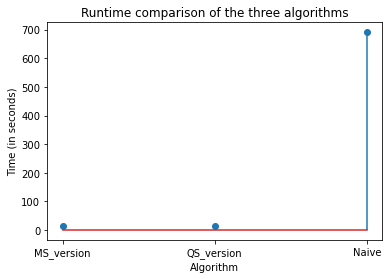

In [31]:
import matplotlib.pyplot as plt
x = ['MS_version', 'QS_version', 'Naive']
y = [MS, QS, N]
plt.title('Runtime comparison of the three algorithms')
plt.xlabel('Algorithm')
plt.ylabel('Time (in seconds)')
plt.stem(x, y, use_line_collection=True)
plt.show()

##### From the graph above, it emerges that `Naive` is the absolute loser while `MS_version` and `QS_version` are two candidates. In order to choose between the two we need to get deep into analysing these two algorithms. 

##### From the second point of RQ7, we know that the complexity of `QS_version` is expected to be in the order of that of `MS_version`. So this time we prevent from using the `getime` function.
##### That is because `getime` outuputs a result that fluctuates, and so we cannot simply rely on that result.
##### Thus, in order to be more certain of which algorithm is faster we use the `%timeit` magic function with `32` repetitions. This way, we smooth some of the variability inherent in the previous results.

In [22]:
%timeit -r 32 MS_version(file) # runtime for MS

15.1 s ± 1.07 s per loop (mean ± std. dev. of 32 runs, 1 loop each)


In [26]:
mapReduce(file) 

In [23]:
%timeit -r 32 QS_version(file) # runtime for QS

13.8 s ± 1.29 s per loop (mean ± std. dev. of 32 runs, 1 loop each)


##### Then, we plot the results.

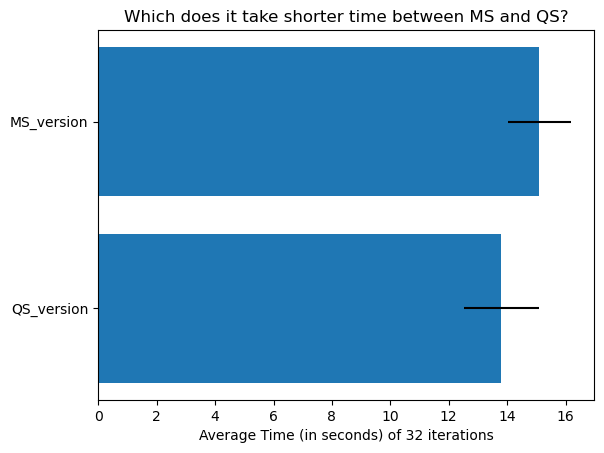

In [32]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
algorithms = ('MS_version', 'QS_version')
y_pos = np.arange(len(algorithms))
# original run x = np.array([13.4,13.1])
# original run error = np.array([0.656,0.752])
x = np.array([15.1,13.8])
error = np.array([1.07,1.29])

ax.barh(y_pos, x, xerr=error, align='center')
ax.set_yticks(y_pos, labels=algorithms)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Average Time (in seconds) of 32 iterations')
ax.set_title('Which does it take shorter time between MS and QS?')

plt.show()

##### Answer: There is no clear winner. However, since, as we previously said, `quicksort` sorts a list of items *in place* (to wit, with no need of additional storage space) we tend to prefer `QS_version` over `MS_version`

## 7.5. The MapReduce Algorithm

We are asked to solve the usual problem by using a *MapReduce* sorting algorithm.
We decided to implement an algorithm made of three functions:
1. a `mapper` function that creates a dictionary storing average grade as key and students' names as values
2. a `shuffler` function that shuffle the output of the previous function by means of the *SortedDict* data structure
3. a `reducer` function that takes as argument the output of the `shuffler` and returns a dictionary having the unique students' names as key and average grades as values.

This way, we obtained the expected result.

In [7]:
def mapper(items):
    
    """ Produces a set of intermediate key/value pairs.
    
        Args: 
            - item (list of lists)
        
        Returns:
            - map_dict (dictionary): {gpa1:[student1,student2]...}
    """
    
    map_dict = {}
    for item in items:
        if item[1] not in list(map_dict.keys()):
            map_dict.setdefault(item[1], [])
            map_dict[item[1]].append(item[0]) 
        else:
            map_dict[item[1]].append(item[0])
        
    return map_dict


def shuffler(map_dict):

    """ Shuffle the items of the output of the previous function
        
        Args:
            - map_dict (dictionary)
            
        Returns:
            - shuff_dict (SortedDict)
    """
    
    from sortedcontainers import SortedDict
    shuff_dict = SortedDict(map_dict)
    return shuff_dict

def reducer (shuff_dict):
    
    """ Reduce the items of the output of the previous function
        
        Args:
            - shuff_dict (SortedDict)
            
        Returns:
            - reduc_dict (dict)
    """
    reduc_dict = {value: key for key in shuff_dict for value in sorted(shuff_dict[key],reverse=True)}
    return reduc_dict


def mapReduce_sort(items):
    
    """ Puts 'mapper', 'shuffler',and 'reducer' together
        
        Args:
            - items (list of lists)
            
        Returns:
            - reduc_dict (dict)
    """
    map_dict = mapper(items)
    shuff_dict = shuffler (map_dict)
    reduc_dict = reducer (shuff_dict)
    return reduc_dict
        

def mapReduce(file):

    """ It is the same algorithm as the previous ones with two modifications:
            a. mapReduce_sort is used as sorting algorithm
            b. in writing the output txt file, the last element is written first.
                (that is due to the way mapReduce_sort has been constructed)
        
        Args:
            - file (txt file)
            
        Returns:
            - writes 'RankingList.txt' (txt file)
    """
    
    items = [] # initialize a list that will store lists of name-gpa pairs

    ''' open up the txt file '''
    with open(file) as f:
        
        ''' parse the txt file '''
        lines = f.readlines()[0:1] # parse first line
        for line in lines:
            line = line.strip().split() 
            n = int(line[0]) # extract n of students
            m = int(line[1]) # extract n of grades for each student
            
        f.seek(0) # reset the file pointer    
        
        lines = f.readlines()[1:] #parse from the second line to end
        for line in lines:
            line = line.strip().split() # a list of all the character of a particular line
            grades = list(map(int,line[2:])) #list of grades of a paricular student
            name = ' '.join([line[0],line[1]])  # join first and last name of a particuar student in a string
            ''' compute the average grade of a particular student '''
            summ = 0 # initialize the sum
            for grade in grades:
                summ += grade #increase the sum by grade
            gpa = round(summ/m,2) # compute the average and round it to the 2nd decimal point
            item = [name,gpa] # associate the average grade to each name
            items.append(item)
    items = mapReduce_sort(items)
    ''' write a txt file called 'RankingList.txt', containing the rank of the sudents'''
    with open('RankingList.txt', 'w') as f:
        items = list(items.items())
        for i in range(len(items)-1,-1,-1): # loop through d_items
            # write each item on a new line
            f.write(str(items[i][0])+ ' ' + str(items[i][1])) # write a line containing the name and average grade of a particular student
            f.write('\n')
    return 


In [34]:
%timeit -r 32 mapReduce(file)

12.7 s ± 427 ms per loop (mean ± std. dev. of 32 runs, 1 loop each)


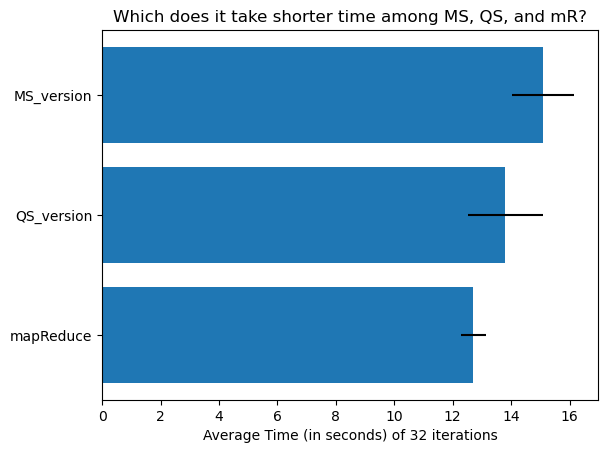

In [35]:
import matplotlib.pyplot as plt
import numpy as np

plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
algorithms = ('MS_version', 'QS_version','mapReduce')
y_pos = np.arange(len(algorithms))
# original run x = np.array([13.4,13.1,12.8])
# original run error = np.array([0.656,0.752,0.527])
x = np.array([15.1,13.8, 12.7])
error = np.array([1.07,1.29, 0.427])

ax.barh(y_pos, x, xerr=error, align='center')
ax.set_yticks(y_pos, labels=algorithms)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Average Time (in seconds) of 32 iterations')
ax.set_title('Which does it take shorter time among MS, QS, and mR?')

plt.show()

##### Now, as our last resource we implement a MapResource Algorith using the `Elastic MapReduce` present in `AWS`

In [ ]:
file = sc.textFile('s3://hw3-applicationsinfo.txt/ApplicantsInfo.txt') #read the file

In [ ]:
def mapReduce_sort2(file):
    """ A function implemented in spark and written in Python. 

        Args:
            - file (txt file)
            
        Returns:
            - the ranking of students in a list of lists
    """
    first = file.collect()[0] # extract the first row
    grades = float(first.split(' ')[1]) # save the number of grades
    students = int(first.split(' ')[0]) # save the number of students
    output = file.filter(lambda row : row!=first)\ # filter s.t. to exclude the first row
    .map(lambda row:row.split())\  # map for each row
    .map(lambda row: (sum([float(vote) for vote in row[2:]])/(grades), row[0],row[1]))\ # map for average grade, first an second name 
    .takeOrdered(students,(lambda row : (-row[0],row[1],row[2]))) # take the wanted order
    return output

def mapReduce(file):
     """ It uses the previous function to get the ranking of the students. 
         Then, writes the ranking in a txt file.
        
        Args:
            - file (txt file)
            
        Returns:
            - writes 'RankingList.txt' (txt file)
    """
    output = mapReduce_sort2(file)
    ''' write a txt file called 'RankingList.txt', containing the rank of the sudents'''
    with open('RankingList.txt', 'w') as f:
        for i in range(0,len(output)): # loop through d_items
            # write each item on a new line
            f.write(str(output[i][0])+ ' ' + str(output[i][1])) # write a line containing the name and average grade of a particular student
            f.write('\n')
    return 

##### We cannot run this code on Jupyter simply because it wont work. But here below is a screenshot of its performance.

In [37]:
import time
summ = 0
for i in range(32):
    start_time = time.time()
    mapReduce(file)
    summ += time.time() - start_time
print(f"Execution time: {round(summ/32,1)}")

VBox()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

Execution time: 9.8

In [36]:
MS, QS, PyMR, SpMR = 15.1,13.8,12.7,9.8

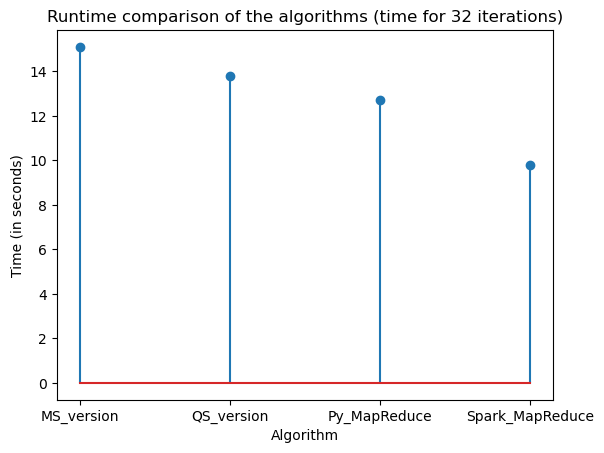

In [39]:
import matplotlib.pyplot as plt
x = ['MS_version', 'QS_version', 'Py_MapReduce', 'Spark_MapReduce']
y = [MS,QS,PyMR,SpMR]
plt.title('Runtime comparison of the algorithms (time for 32 iterations)')
plt.xlabel('Algorithm')
plt.ylabel('Time (in seconds)')
plt.stem(x, y, use_line_collection=True)
plt.show()